In [1]:
import random
import sys
import matplotlib.pyplot as plt
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.basilisk_amm import ConstantProductPoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import random_swaps, steady_swaps, constant_product_arbitrage
from model.amm.global_state import GlobalState, fluctuate_prices

# same seed, same parameters = same simulation result
random.seed(42)

price_dict = {
    'R1': 3.0,
    'R2': 0.7,
    'USD': 1
}

initial_state = GlobalState(
    pools={
        'USD/R1': ConstantProductPoolState(
            tokens={
                'USD': 10000000,
                'R1': 10000000 / price_dict['R1']
            },
            trade_fee=0.01
        ),
        'R1/R2': ConstantProductPoolState(
            tokens={
                'R1': 10000000 / price_dict['R1'],
                'R2': 10000000 / price_dict['R2'],
            },
            trade_fee=0.01
            # fee_function = ConstantProductPoolState.custom_slip_fee(0.1)
        )
    },
    agents = {
        # 'Trader1': Agent(
        #     holdings={'R1': 100000, 'USD': 100000},
        #     trade_strategy=random_swaps(
        #         pool_id='USD/R1', 
        #         amount={
        #             'R1': 1000,
        #             'USD': 1000
        #         },
        #         randomize_amount=True
        #     )
        # ),
        'Trader2': Agent(
            holdings={'R1': 100000, 'R2': 100000},
            trade_strategy=steady_swaps(
                pool_id='R1/R2', 
                usd_amount=1000
            )
        ),
        'Arbitrageur1': Agent(
            holdings={'USD': 1000000},
            trade_strategy=constant_product_arbitrage('USD/R1', minimum_profit=1)
        ),
        'Arbitrageur2': Agent(
            holdings={'USD': 1000000},
            trade_strategy=constant_product_arbitrage('R1/R2', minimum_profit=0)
        )
    },
    external_market=price_dict,
    evolve_function=fluctuate_prices(volatility={'R1': 1, 'R2': 1}, trend={'R1': 1, 'R2': 1})
)

events = run.run(initial_state, time_steps=1000)

events = processing.postprocessing(events, optional_params=['holdings_val', 'pool_val', 'token_count', 'trade_volume'])
print('finished.')

Starting simulation...
Execution time: 0.957 seconds.
finished.


<AxesSubplot:title={'center':'agent: Arbitrageur2 holdings USD '}>

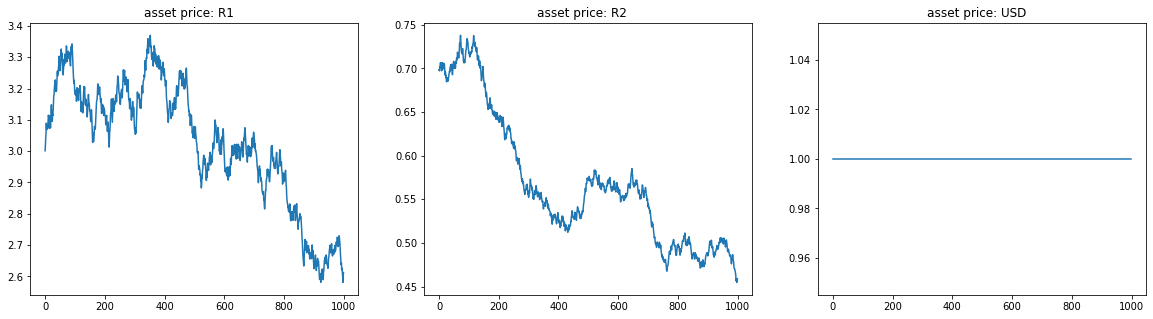

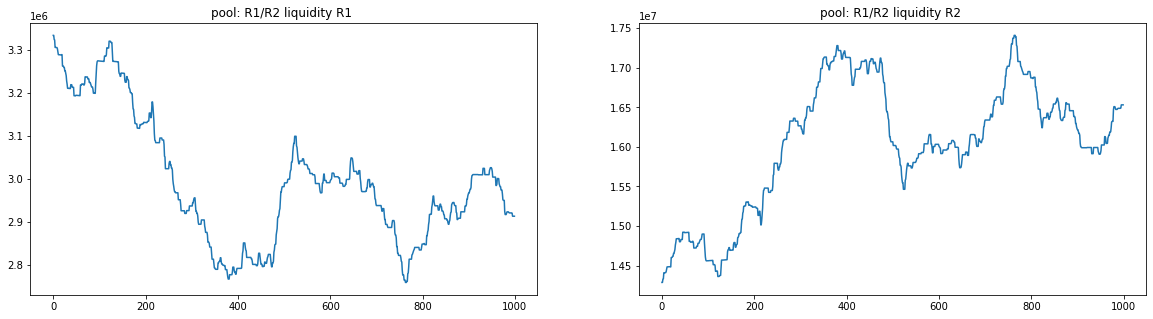

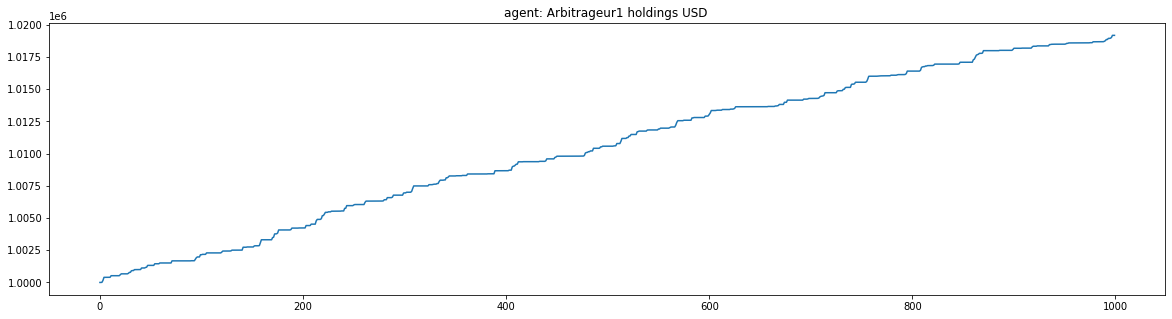

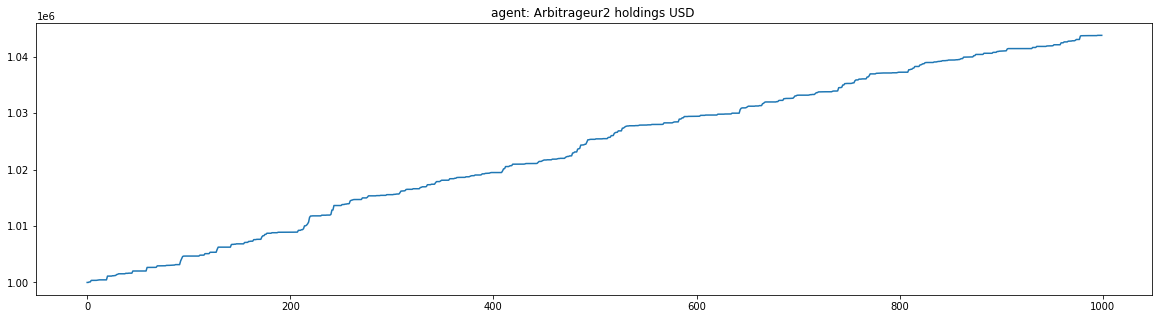

In [2]:
pu.plot(events, asset='all')
pu.plot(events, pool='R1/R2', prop='liquidity')
pu.plot(events, agent='Arbitrageur1', prop='holdings', key='USD')
ax = pu.plot(events, agent='Arbitrageur2', prop='holdings', key='USD')
pu.plot(events, agent='Arbitrageur3', prop='holdings', key='USD', subplot=ax)
# pu.plot(events, agent='Trader2', prop='trade_volume', time_range=(100, 200))

In [3]:
unprofitable_trades = 0
total_trades = len(events) * 2
for i in range(1, len(events)):
    if events[i]['state'].agents['Arbitrageur1'].holdings['USD'] < events[i-1]['state'].agents['Arbitrageur1'].holdings['USD']:
        unprofitable_trades += 1
    if events[i]['state'].agents['Arbitrageur2'].holdings['USD'] < events[i-1]['state'].agents['Arbitrageur2'].holdings['USD']:
        unprofitable_trades += 1
        
print (f'Arbitrageurs made unprofitable trades {round(unprofitable_trades / total_trades * 100, 2)}% of the time.')

Arbitrageurs made unprofitable trades 0.0% of the time.


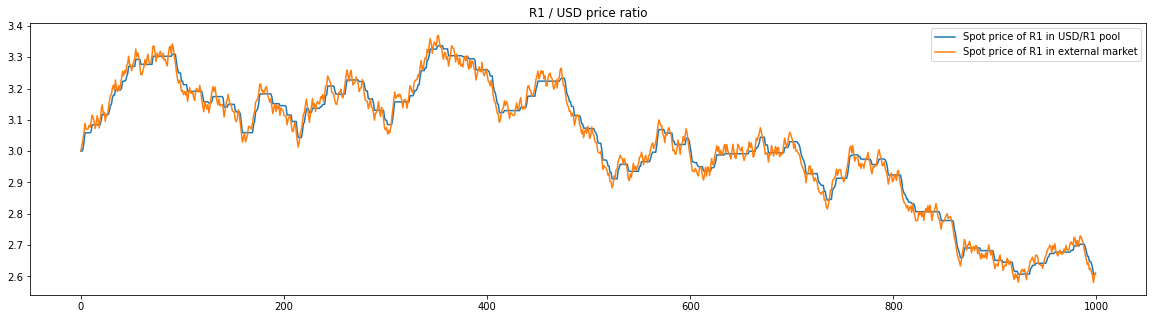

In [4]:
usd_pool = pu.get_datastream(events, pool='USD/R1', prop='liquidity', key='USD')
R1_pool = pu.get_datastream(events, pool='USD/R1', prop='liquidity', key='R1')
R1_ratio = [usd_pool[i] / R1_pool[i] for i in range(len(events))]
plt.figure(figsize=(20,5))
ax = plt.subplot(111, title='R1 / USD price ratio')
zoomRange = 1000
ax.plot(range(zoomRange), R1_ratio[:zoomRange], label='Spot price of R1 in USD/R1 pool')
pu.plot(events[:zoomRange], asset='R1', subplot=ax, label='Spot price of R1 in external market')
ax.legend()

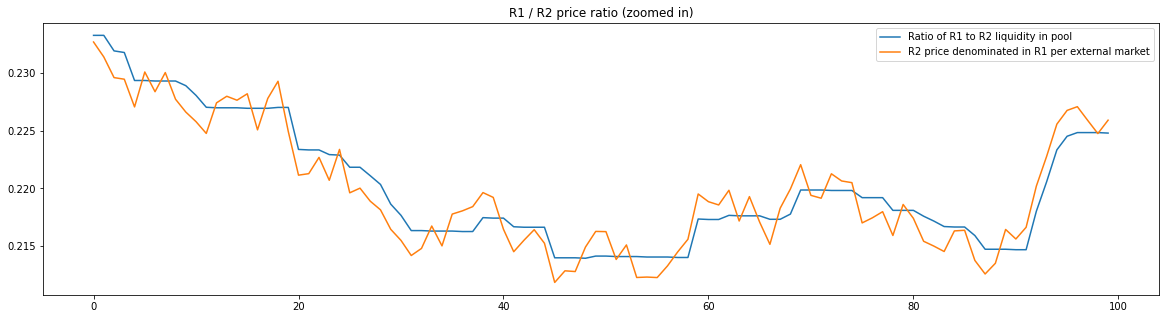

In [5]:
R2_pool = pu.get_datastream(events, pool='R1/R2', prop='liquidity', key='R2')
R1_pool = pu.get_datastream(events, pool='R1/R2', prop='liquidity', key='R1')
R1_price = pu.get_datastream(events, asset='R1')
R2_price = pu.get_datastream(events, asset='R2')
pool_ratio = [R1_pool[i] / R2_pool[i] for i in range(len(events))]
price_ratio = [R2_price[i] / R1_price[i] for i in range(len(events))]
plt.figure(figsize=(20,5))
ax = plt.subplot(111, title='R1 / R2 price ratio (zoomed in)')
zoomRange = 100
ax.plot(range(zoomRange), pool_ratio[:zoomRange], label='Ratio of R1 to R2 liquidity in pool')
ax.plot(range(zoomRange), price_ratio[:zoomRange], label='R2 price denominated in R1 per external market')
# ax.plot([0, zoomRange], [1, 1])
ax.legend()

# pu.plot(events, agent='Arbitrageur2', prop='trade_rejected', time_range=(0, zoomRange))
# ax = pu.plot(events, agent='Arbitrageur2', prop='projected_profit', time_range=(0, zoomRange))
# ax.plot([0, zoomRange], [0, 0])